In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

%matplotlib inline

In [2]:
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k)
                          for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
        
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k)
                          for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [3]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
])
path = './MNIST_data'
batch_size = 32

In [4]:
test_data = datasets.MNIST(path, train=False,
                           download=True, transform=mnist_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

train_data = datasets.MNIST(path, train=True,
                            download=True, transform=mnist_transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([32, 1, 28, 28])

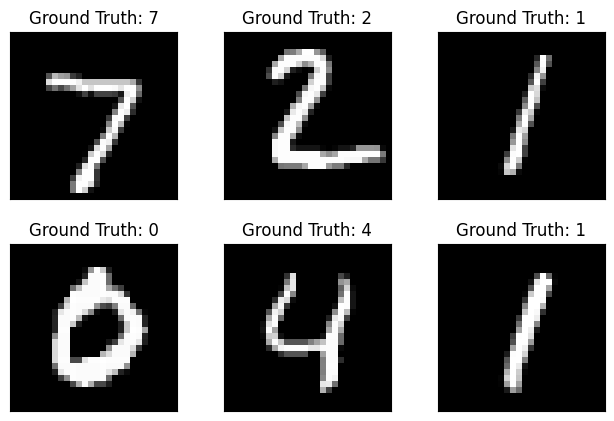

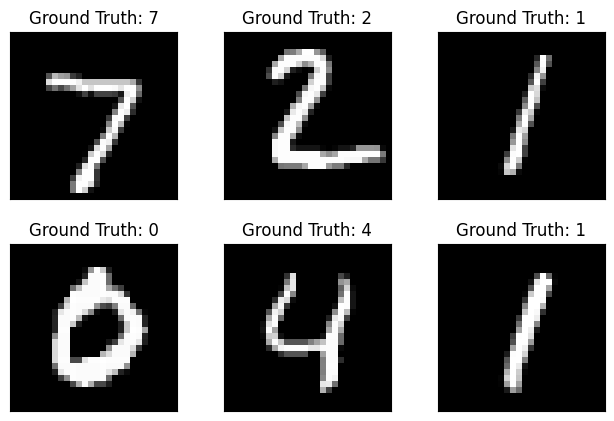

In [7]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [32]:
class Net(nn.Module):
    def __init__(self, lr=1e-4, l2=0.01, grad_clip=False, grad_norm=1.0):
        super(Net, self).__init__()
        self.grad_clip = grad_clip
        self.grad_norm = grad_norm
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.2)
        self.optim = optim.AdamW(self.parameters(), lr=lr, weight_decay=l2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.bn(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        pred = output.data.max(1, keepdim=True)[1]
        t = target.data.view_as(pred)
        self._correct = pred.eq(t).to(torch.float).mean()
        return self._loss

In [33]:
models = {'default': Net(),
          'grad_clip': Net(grad_clip=True, grad_norm=1.)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [34]:

def train(models, loader, epoch, log=None):
    train_size = len(loader.sampler)
    for batch_idx, (data, target) in enumerate(loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            if model.grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), model.grad_norm)
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [35]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c.to(torch.float) / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [36]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(models, train_loader, epoch, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [0/60000 (0%)]	Losses default: 2.315580 grad_clip: 2.274857
Train Epoch: 1 [6400/60000 (11%)]	Losses default: 1.130127 grad_clip: 1.168664
Train Epoch: 1 [12800/60000 (21%)]	Losses default: 0.715472 grad_clip: 0.625420
Train Epoch: 1 [19200/60000 (32%)]	Losses default: 0.460427 grad_clip: 0.409721
Train Epoch: 1 [25600/60000 (43%)]	Losses default: 0.381070 grad_clip: 0.348100
Train Epoch: 1 [32000/60000 (53%)]	Losses default: 0.320639 grad_clip: 0.297264
Train Epoch: 1 [38400/60000 (64%)]	Losses default: 0.433985 grad_clip: 0.339043
Train Epoch: 1 [44800/60000 (75%)]	Losses default: 0.366778 grad_clip: 0.498247
Train Epoch: 1 [51200/60000 (85%)]	Losses default: 0.366846 grad_clip: 0.417272
Train Epoch: 1 [57600/60000 (96%)]	Losses default: 0.073682 grad_clip: 0.144399
Train Epoch: 1 [60000/60000 (100%)]	Losses default: 0.247295 grad_clip: 0.269469
Test set:
default: Loss: 0.1911	Accuracy: 9468.0/10000 (95%)
grad_clip: Loss: 0.1906	Accuracy: 9440.0/10000 (94%)

Train Epoc

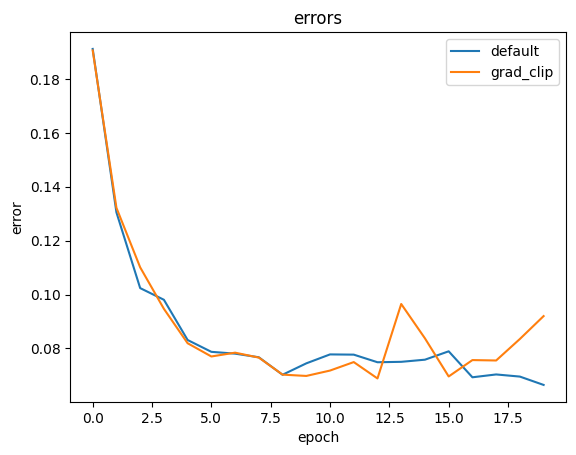

In [37]:
plot_graphs(test_log, 'loss')

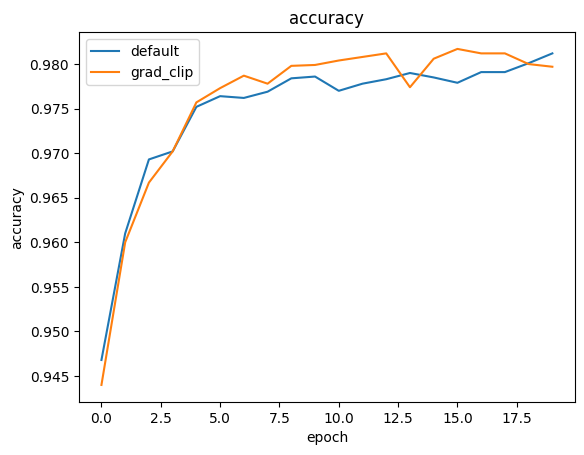

In [38]:
plot_graphs(test_log, 'accuracy')